# Cheese Classifier

This notebook creates and exports a convolutional neural network model trained to classify cheese. It is based on Lesson 2 from the fast.ai Deep Learning Course, Part 1 from 2019 (https://github.com/fastai/course-v3/).

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *
from fastai.vision.gan import *
from fastai.widgets import *

This notebook was made with the following version of fastai:

In [3]:
__version__

'1.0.50.post1'

## 1. Creating the Dataset

A few hundreds of pictures are manually selected on Google Image using the [gi2ds](https://github.com/toffebjorkskog/ml-tools) tool. They are saved as list of URLs into the `data` folder:

In [4]:
path = Path("data")
url_files = [child for child in path.iterdir() if child.name.startswith("urls_")]
url_files

[PosixPath('data/urls_saint-nectaire.txt'),
 PosixPath('data/urls_reblochon.txt'),
 PosixPath('data/urls_roquefort.txt'),
 PosixPath('data/urls_comté.txt'),
 PosixPath('data/urls_cantal.txt'),
 PosixPath('data/urls_camembert.txt')]

For each list of URLs, a new folder is created and all images are downloaded inside it. 

Invalid images are deleted and images that are too big are resized to 500px.

In [ ]:
for file in url_files:
    name = file.stem[5:]
    print(name)
    dest = path/name
    dest.mkdir(parents=True, exist_ok=True)
    download_images(file, dest, max_pics=200)
    verify_images(dest, delete=True, max_size=500)

## 2. Cleaning Up the Data

Some images may be unrelated and/or duplicates. To remove them, a dataset is created with a training set and no validation set.

In [6]:
data = (
    ImageList.from_folder(path)
    .split_none()
    .label_from_folder()
    .transform(get_transforms(), size=224)
    .databunch()
    .normalize(imagenet_stats)
)

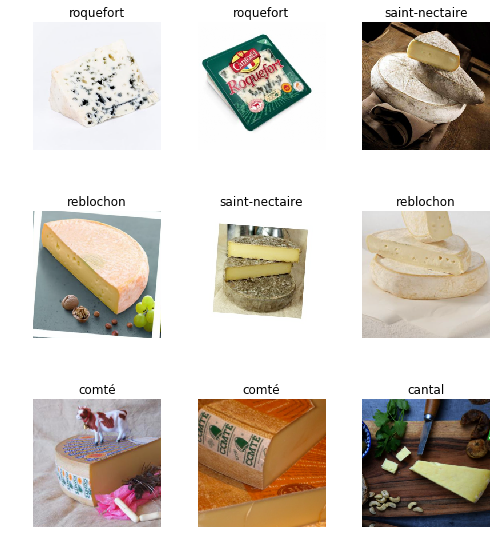

In [7]:
data.show_batch(rows=3, figsize=(7,8))

In [8]:
data.classes

['camembert', 'cantal', 'comté', 'reblochon', 'roquefort', 'saint-nectaire']

A model is trained on this set: its top losses are used to detect the most unrelated images.

In [9]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)
learn.fit_one_cycle(2)

Unrelated images are removed with the ImageCleaner widget:

In [ ]:
ds, idxs = DatasetFormatter().from_toplosses(learn)
ImageCleaner(ds, idxs, path);

The same widget is used to remove duplicate images.

In [ ]:
ds, idxs = DatasetFormatter().from_similars(learn)
ImageCleaner(ds, idxs, path, duplicates=True);

The cleaned dataset is saved by the widget in a CSV file.

## 3. Training the Model

The newly created `cleaned.csv` is loaded. To track the progress of the new model, 20% of the images are separated into a validation set.

In [12]:
data = ImageDataBunch.from_csv(
    path,
    valid_pct=0.2,
    csv_labels="cleaned.csv",
    ds_tfms=get_transforms(),
    size=224,
    num_workers=4,
).normalize(imagenet_stats)

A new resnet34 model is trained against this data.

In [13]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.944060,0.930280,0.305419,00:06
1,1.390237,0.607543,0.211823,00:06
2,1.101882,0.585000,0.221675,00:06
3,0.919080,0.577722,0.221675,00:06


After a few epochs, the error rate stops improving. To further improve it, the deeper layers of the NN are unfreezed.

In [14]:
learn.unfreeze()

The learning-rate finder is used to compute the loss resluting from different error rates:

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


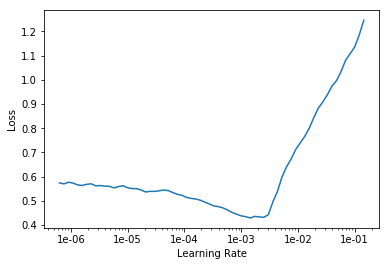

In [15]:
learn.lr_find()
learn.recorder.plot()

The longest downwards slope will be used as the learning rates for deeper layers. It is located roughly between $10^{-5}$ and $10^{-3}$.

In [16]:
learn.fit_one_cycle(8, max_lr=slice(3e-5,3e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.556073,0.534507,0.187192,00:07
1,0.483273,0.456348,0.172414,00:07
2,0.400027,0.400567,0.133005,00:07
3,0.322339,0.411943,0.142857,00:07
4,0.267215,0.417333,0.137931,00:07
5,0.227438,0.427715,0.128079,00:07
6,0.190201,0.414907,0.137931,00:07
7,0.165728,0.409437,0.133005,00:07


The model is ready to be exported.

In [17]:
learn.export()

## 4. Interpretating the Results

Results can be interpreted using the ClassificationInterpretation class.

In [18]:
interp = ClassificationInterpretation.from_learner(learn)

Top losses are shown, i.e. wrong guesses where the model was the most confident.

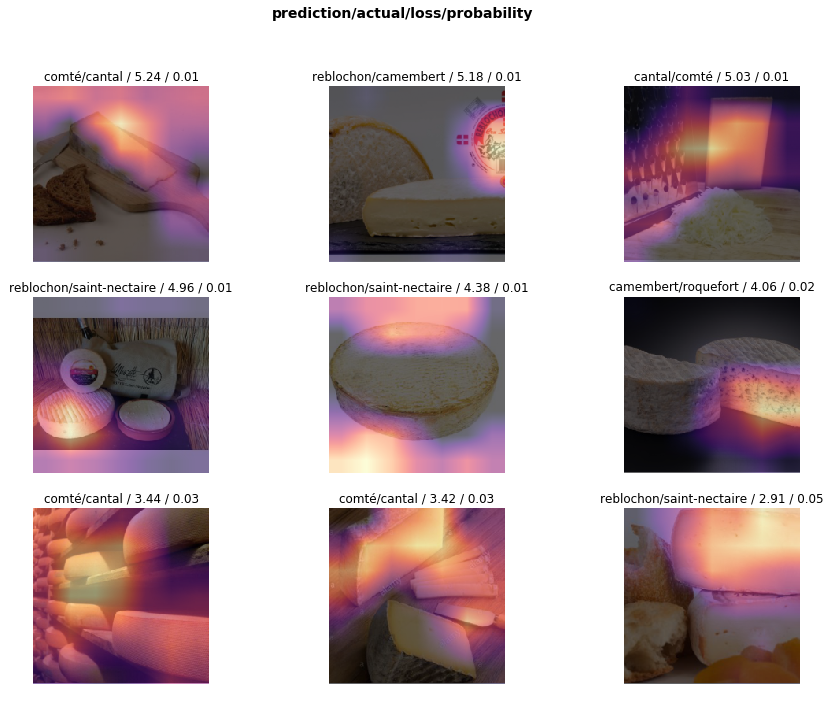

In [19]:
interp.plot_top_losses(9, figsize=(15,11))

The confusion matrix sums up the results.

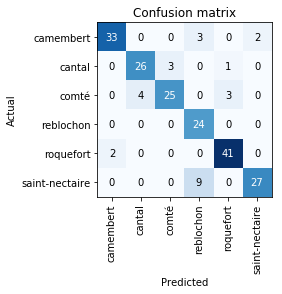

In [20]:
interp.plot_confusion_matrix()

Finally, the most confused function shows classes that were most guessed opposite.

In [21]:
interp.most_confused(min_val=2)

[('saint-nectaire', 'reblochon', 9),
 ('comté', 'cantal', 4),
 ('camembert', 'reblochon', 3),
 ('cantal', 'comté', 3),
 ('comté', 'roquefort', 3),
 ('camembert', 'saint-nectaire', 2),
 ('roquefort', 'camembert', 2)]

## 5. Playing with GANs

In [22]:
def get_data(bs, size):
    return (GANItemList.from_csv(path, csv_name="cleaned.csv", noise_sz=100)
               .split_none()
               .label_from_func(noop)
               .transform(tfms=[[crop_pad(size=size, row_pct=(0,1), col_pct=(0,1))], []], size=size, tfm_y=True)
               .databunch(bs=bs)
               .normalize(stats = [torch.tensor([0.5,0.5,0.5]), torch.tensor([0.5,0.5,0.5])], do_x=False, do_y=True))

In [23]:
data = get_data(128, 64)

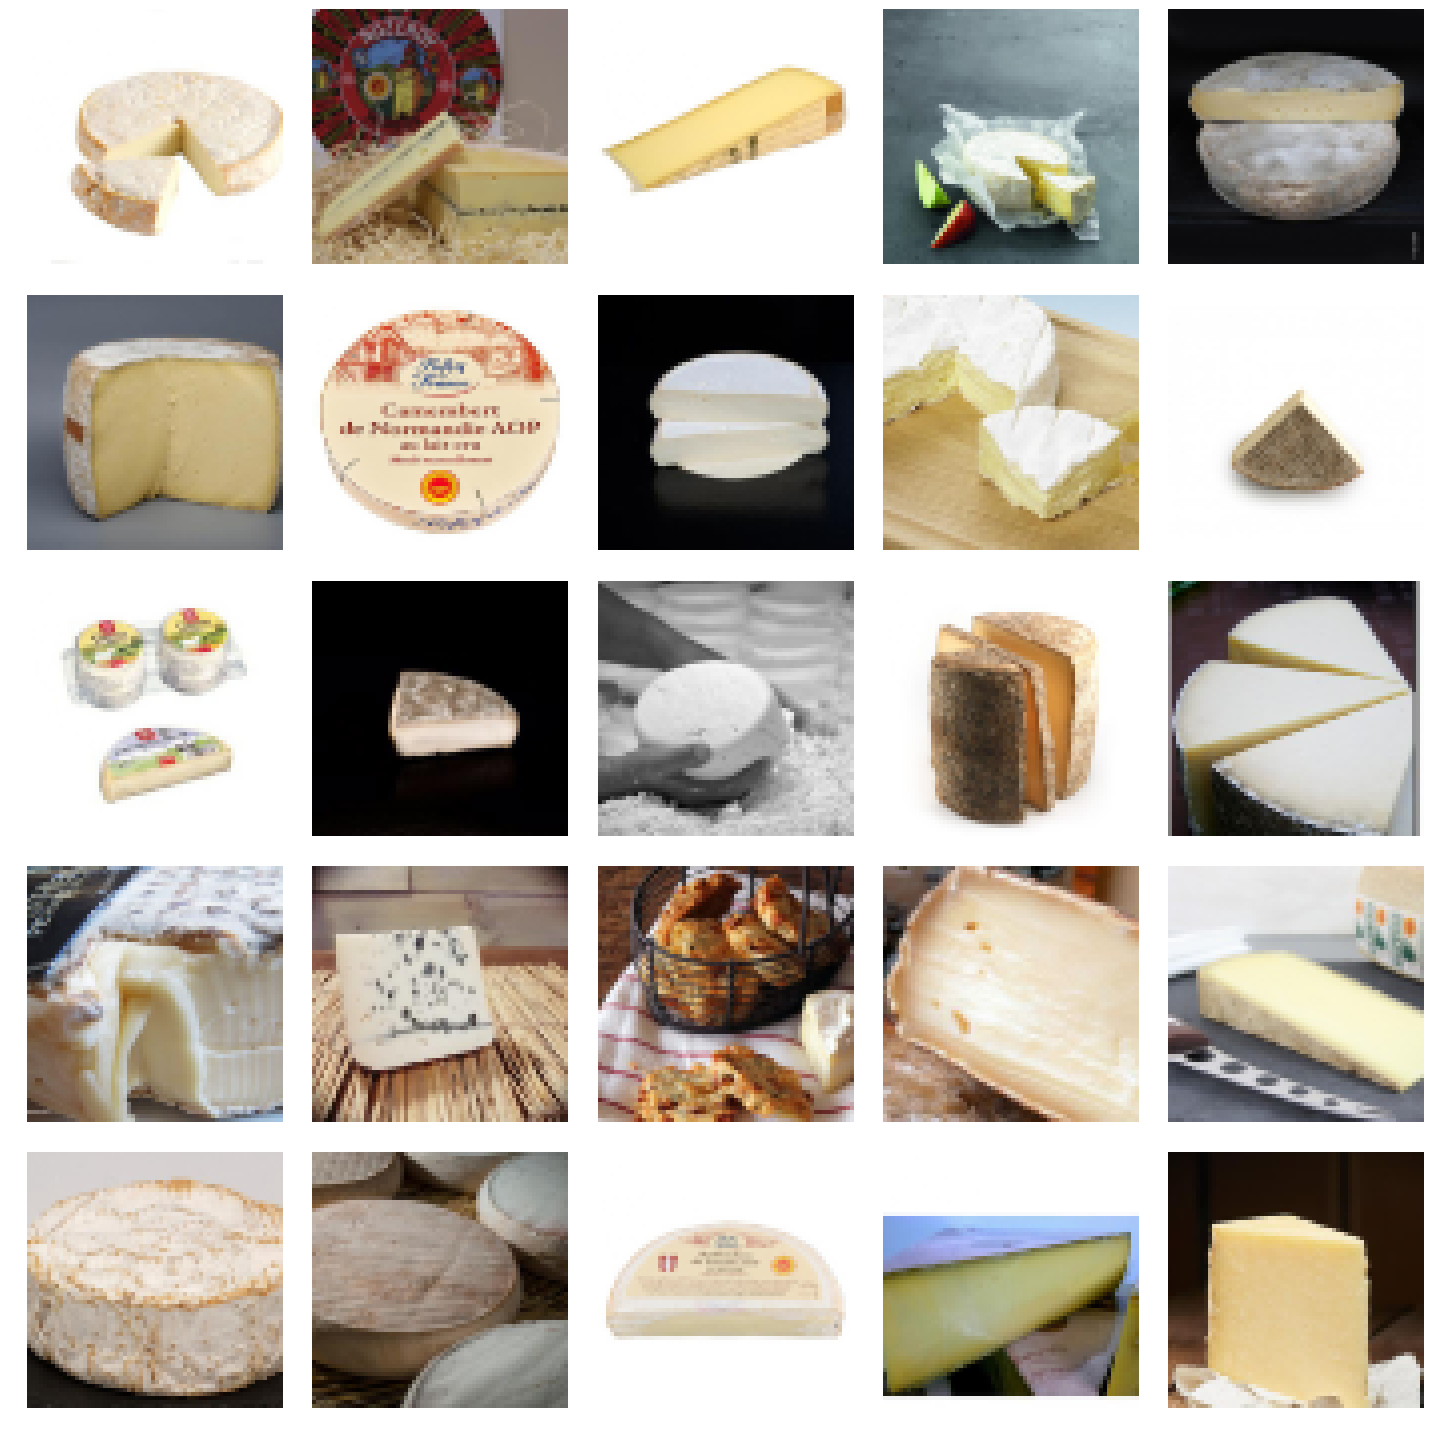

In [24]:
data.show_batch(rows=5)

In [25]:
generator = basic_generator(in_size=64, n_channels=3, n_extra_layers=1)
critic    = basic_critic   (in_size=64, n_channels=3, n_extra_layers=1)

In [26]:
learn = GANLearner.wgan(data, generator, critic, switch_eval=False,
                        opt_func = partial(optim.Adam, betas = (0.,0.99)), wd=0.)

In [ ]:
# learn.load("gan", purge=False)  # Uncomment to load pre-trained GAN

epoch,train_loss,valid_loss,gen_loss,disc_loss,time
0,-0.358520,#na#,0.468277,-0.503149,00:03
1,-0.382847,#na#,0.307667,-0.500726,00:02
2,-0.393968,#na#,0.353315,-0.520687,00:02
3,-0.394579,#na#,0.295362,-0.508942,00:02
4,-0.396382,#na#,0.342733,-0.518900,00:02
5,-0.372629,#na#,0.330640,-0.522079,00:03
6,-0.395224,#na#,0.292596,-0.532324,00:03
7,-0.393809,#na#,0.318867,-0.534076,00:03
8,-0.406491,#na#,0.295421,-0.538200,00:03
9,-0.413132,#na#,0.316792,-0.548262,00:03


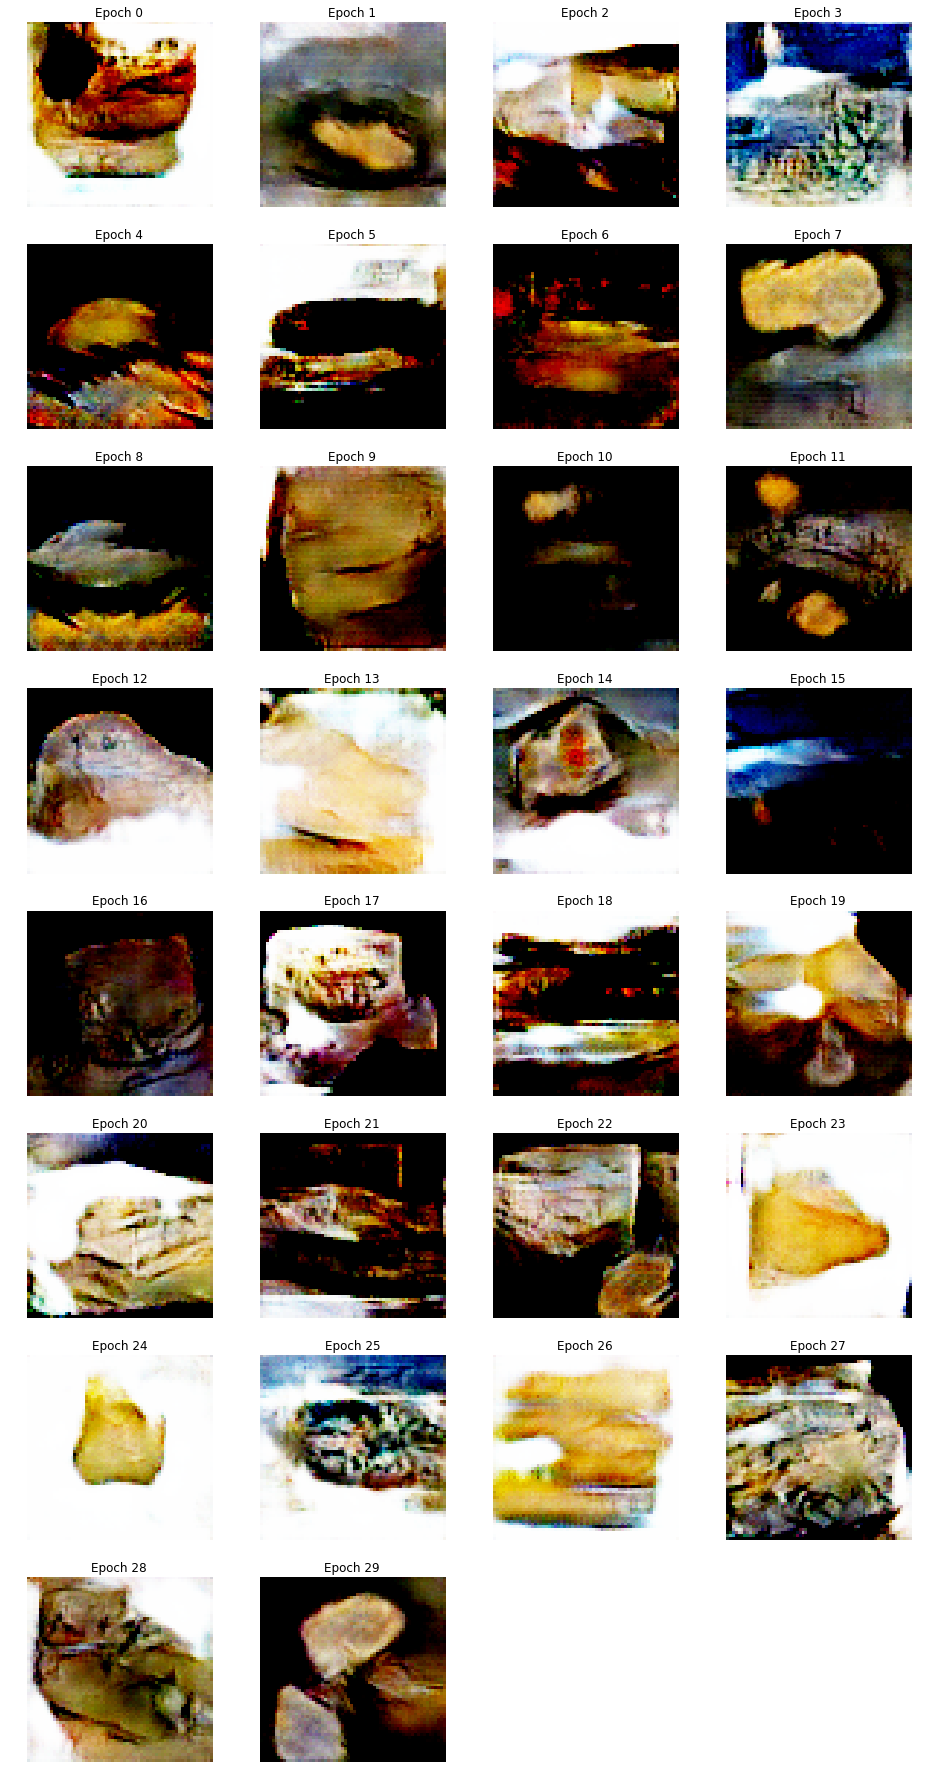

In [28]:
learn.fit(30,2e-4)

In [29]:
learn.save("gan")